In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from iminuit import Minuit
from iminuit.cost import LeastSquares
import pickle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from iminuit import Minuit
from iminuit.cost import LeastSquares
def configure_plotting():
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['savefig.facecolor'] = 'white'
    plt.rcParams['savefig.bbox'] = 'tight'
    hep.style.use(hep.style.CMS)

In [2]:
with open('../../genIII_data/JLab/Beam/Beam1_0-Cal.pkl', 'rb') as file:
    # Load the data from the pickle file
    din = pickle.load(file)
with open("geometry.pkl", 'rb') as file:
    geometry = pickle.load(file)

In [13]:
def get_energy_at_z(beam_lg_mips, z_target, tol=1e-6):
    lg_mips_at_z = []

    for event in beam_lg_mips:
        for entry in event:
            lg_mip, x, y, z = entry
            if abs(z - z_target) < tol and lg_mip > 0:
                lg_mips_at_z.append(lg_mip)

    return lg_mips_at_z

def gauss(x, A, mu, sigma):
    return A * np.exp(-((x - mu) ** 2) / (2. * sigma ** 2))

In [4]:
# Step 1: Get unique sorted z values
z_values_sorted = sorted(geometry["z"].unique())  # ascending order

# Step 2: Build the list of arrays
energy_by_layer = []
for z in z_values_sorted:
    print("Layer")
    energy = get_energy_at_z(din, z)
    energy_by_layer.append(np.array(energy))

Layer
Layer
Layer
Layer
Layer
Layer
Layer
Layer
Layer
Layer
Layer
Layer
Layer
Layer
Layer


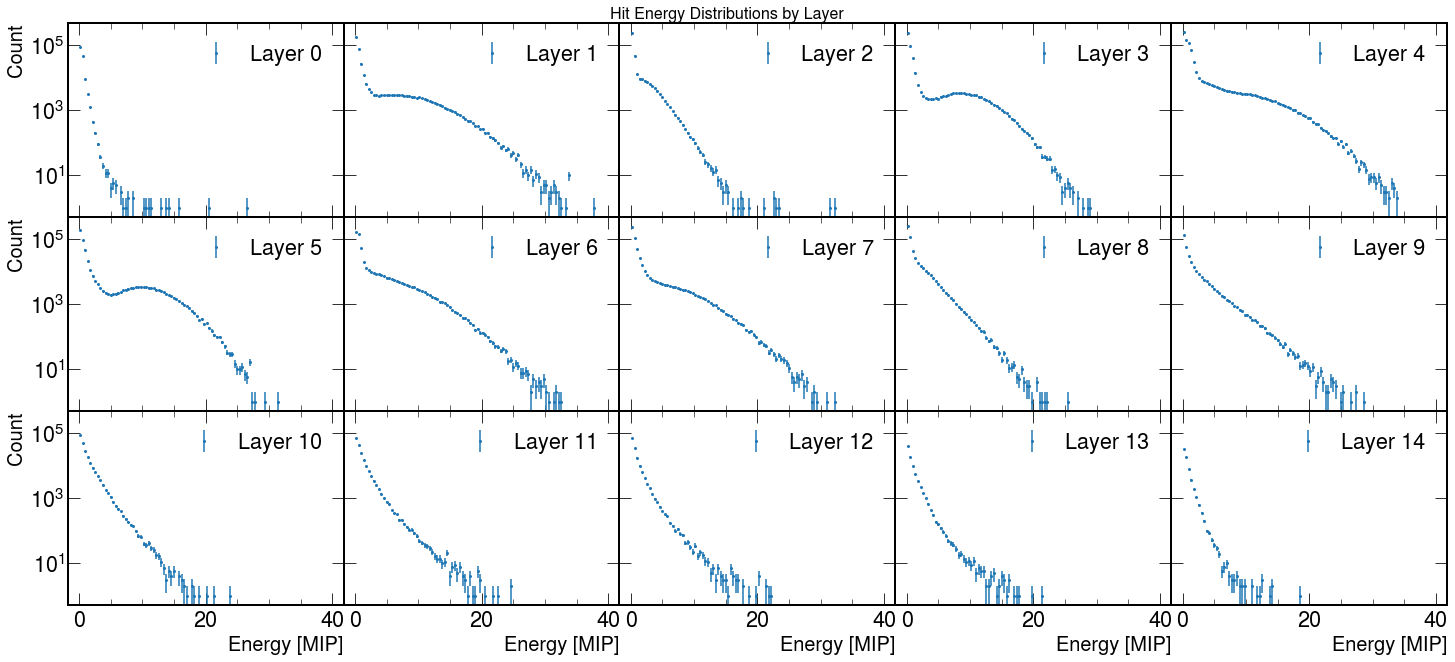

In [7]:
configure_plotting()
layerAvg = []
layerStd = []
# Assuming mips_by_layer is already defined from earlier
num_layers = len(energy_by_layer)
cols = 5  # You can change this layout
rows = (num_layers + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), sharey=True)
axes = axes.flatten()

# Histogram settings
bins = 100
range_ = (0, 40)

for i, data in enumerate(energy_by_layer):
    counts, bin_edges = np.histogram(data, bins=bins, range=range_)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    errors = np.sqrt(counts)

    ax = axes[i]
    ax.errorbar(bin_centers, counts, yerr=errors, fmt='o', markersize=2, label=f'Layer {i}')
    ax.set_yscale("log")
    ax.legend()
    for ax in axes[-5:]:  # Bottom row (x-axis label)
        ax.set_xlabel("Energy [MIP]", fontsize=20)
    
    for ax in axes[::5]:  # Left column (y-axis label)
        ax.set_ylabel("Count", fontsize=20)
    layerAvg.append(np.mean(data))
    layerStd.append(np.std(data))
    
    
# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.suptitle("Hit Energy Distributions by Layer", fontsize=16, y=1.0)
plt.tight_layout(pad=0.0)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


In [8]:
num_events = din.shape[0]
z_values_sorted = sorted(geometry["z"].unique())
num_layers = len(z_values_sorted)

# Map z -> layer index
z_to_layer_idx = {z: i for i, z in enumerate(z_values_sorted)}

# Initialize array: (num_events, num_layers)
layer_sums = np.zeros((num_events, num_layers))

for evt_idx, event in enumerate(din):
    for energy, x, y, z in event:
        if energy > 0:
            layer_idx = z_to_layer_idx[z]
            layer_sums[evt_idx, layer_idx] += energy


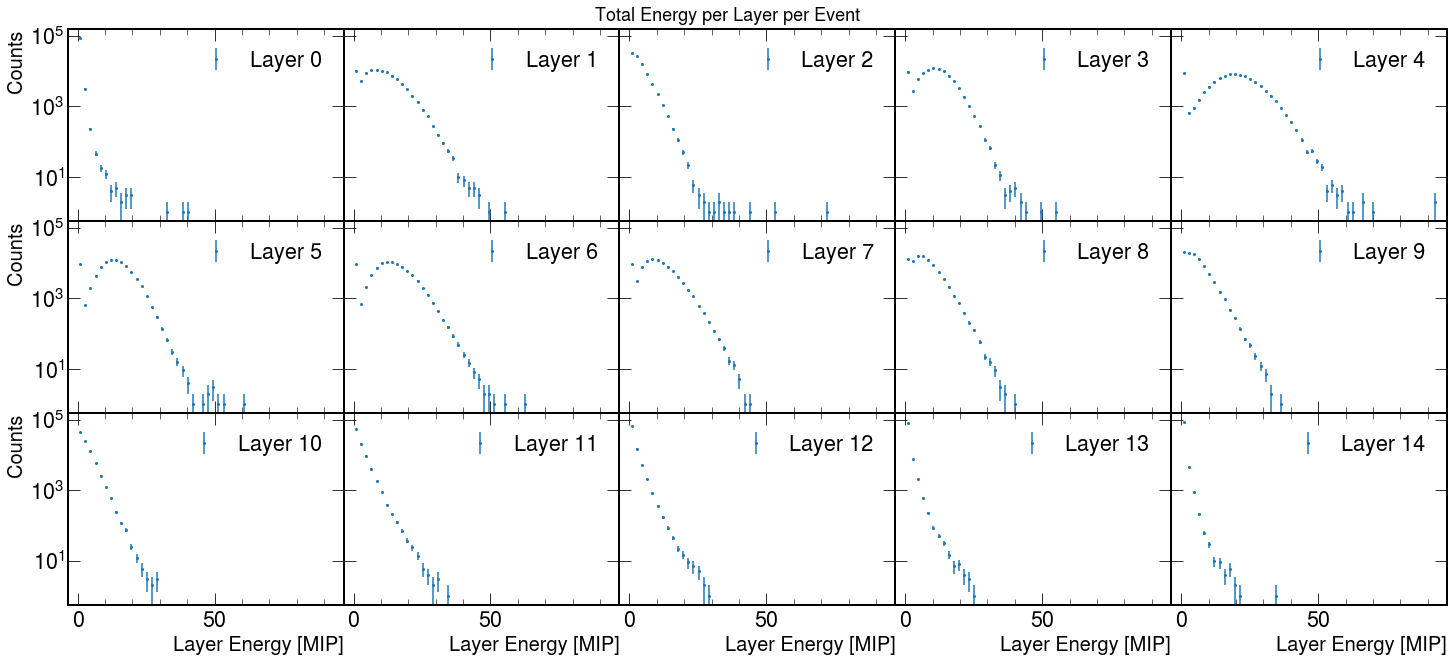

In [9]:
configure_plotting()
cols = 5
rows = (num_layers + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), sharey = True)
axes = axes.flatten()

bins = 50
range_ = (0, layer_sums.max())

for i in range(num_layers):
    data = layer_sums[:, i]
    counts, bin_edges = np.histogram(data, bins=bins, range=range_)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    errors = np.sqrt(counts)

    ax = axes[i]
    ax.errorbar(bin_centers, counts, yerr=errors, fmt='o', markersize=2, label=f'Layer {i}')
    ax.set_yscale('log')
    ax.legend()

# Label only bottom row and left column
for ax in axes[-cols:]:
    ax.set_xlabel("Layer Energy [MIP]", fontsize=20)
for ax in axes[::cols]:
    ax.set_ylabel("Counts", fontsize=20)

# Hide unused axes
for ax in axes[num_layers:]:
    ax.axis("off")

plt.suptitle("Total Energy per Layer per Event", fontsize=18, y=1.0)
plt.tight_layout(pad=0.0)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


In [10]:
evt_energy = []

for evt_idx, event in enumerate(din):
    energy = 0
    for e, x, y, z in event:
        energy += e
    evt_energy.append(energy)

Text(0.5, 1.0, 'Event Energy')

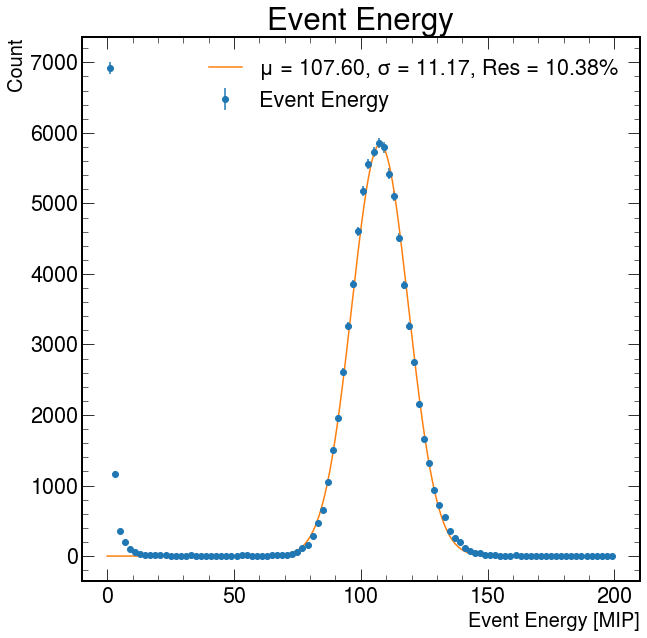

In [19]:


configure_plotting()
data = np.array(evt_energy)
counts, bin_edges = np.histogram(data, bins=100, range=[0, 200])
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
errors = np.sqrt(counts)

plt.errorbar(bin_centers, counts, yerr=errors, fmt='o', label="Event Energy")

# Only use bins with data for fitting
mask = counts > 0
x_data = bin_centers[mask]
y_data = counts[mask]
fit_errors = errors[mask]

# Fit with Minuit
initial_params = [max(y_data), np.mean(data[data>50]), np.std(data[data>50])]
least_squares = LeastSquares(x_data, y_data, fit_errors, gauss)
m = Minuit(least_squares, A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
m.limits["sigma"] = (0, None)
m.migrad()

# Extract results
fit_vals = m.values
fit_errs = m.errors
A_fit = fit_vals['A']
mu_fit = fit_vals['mu']
sigma_fit = fit_vals['sigma']
fit_x = np.linspace(0, 200, 1500)
fit_y = gauss(fit_x, A_fit, mu_fit, sigma_fit)
resolution = (sigma_fit / mu_fit) * 100
plt.plot(fit_x, fit_y, color='tab:orange',
         label=f"μ = {mu_fit:.2f}, σ = {sigma_fit:.2f}, Res = {resolution:.2f}%")
plt.legend()
#plt.yscale("log")
plt.xlabel("Event Energy [MIP]", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.title("Event Energy")

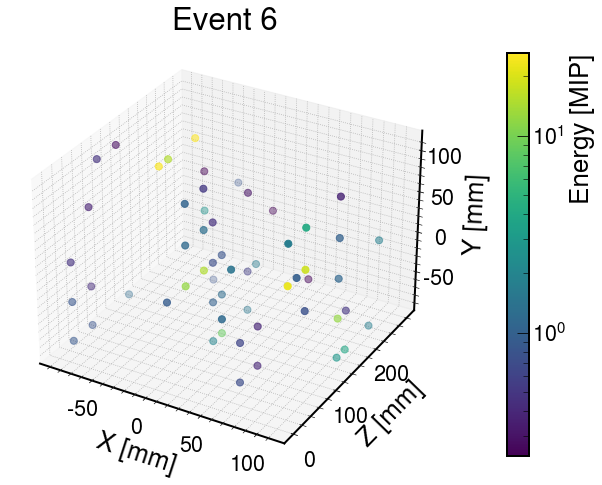

In [35]:
# Get first event's hits
evtnum = 6
event = din[evtnum]

# Filter for hits with energy > 0
energies = np.array([hit[0] for hit in event if hit[0] > 0])
xs = np.array([hit[1] for hit in event if hit[0] > 0])
ys = np.array([hit[2] for hit in event if hit[0] > 0])
zs = np.array([hit[3] for hit in event if hit[0] > 0])

# 3D scatterplot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(xs, zs, ys, c=energies, cmap='viridis', norm=LogNorm(), s=50)

cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
cbar = plt.colorbar(sc, cax=cbar_ax)
cbar.set_label("Energy [MIP]")

ax.set_xlabel("X [mm]", labelpad=15)
ax.set_ylabel("Z [mm]", labelpad=15)
ax.set_zlabel("Y [mm]", labelpad=15)
ax.set_title(f"Event {evtnum}")
plt.subplots_adjust(right=0.85)


plt.show()